<a href="https://colab.research.google.com/github/csaybar/DLcoursera/blob/master/colab/02_Improving%20Deep%20Neural%20Networks_Hyperparameter%20tuning_%20Regularization/week01_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

Welcome to the first assignment of "Improving Deep Neural Networks". 

Training your neural network requires specifying an initial value of the weights. A well chosen initialization method will help learning.  

If you completed the previous course of this specialization, you probably followed our instructions for weight initialization, and it has worked out so far. But how do you choose the initialization for a new neural network? In this notebook, you will see how different initializations lead to different results. 

A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error 

To get started, run the following cell to load the packages and the planar dataset you will try to classify.

In [0]:
#@title init_utils functions

def sigmoid(x):
    """
    Compute the sigmoid of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x
    Arguments:
    x -- A scalar or numpy array of any size.
    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def compute_loss(a3, Y):
    
    """
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

def load_cat_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

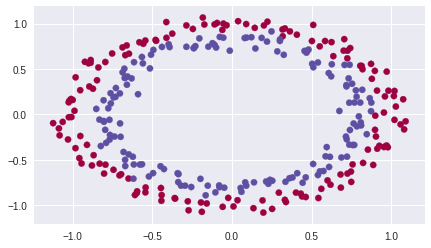

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

You would like a classifier to separate the blue dots from the red dots.

## 1 - Neural Network model 

You will use a 3-layer neural network (already implemented for you). Here are the initialization methods you will experiment with:  
- *Zeros initialization* --  setting `initialization = "zeros"` in the input argument.
- *Random initialization* -- setting `initialization = "random"` in the input argument. This initializes the weights to large random values.  
- *He initialization* -- setting `initialization = "he"` in the input argument. This initializes the weights to random values scaled according to a paper by He et al., 2015. 

**Instructions**: Please quickly read over the code below, and run it. In the next part you will implement the three initialization methods that this `model()` calls.

In [0]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss
        cost = compute_loss(a3, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## 2 - Zero initialization

There are two types of parameters to initialize in a neural network:
- the weight matrices $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- the bias vectors $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

**Exercise**: Implement the following function to initialize all parameters to zeros. You'll see later that this does not work well since it fails to "break symmetry", but lets try it anyway and see what happens. Use np.zeros((..,..)) with the correct shapes.

In [0]:
# GRADED FUNCTION: initialize_parameters_zeros 

def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### END CODE HERE ###
    return parameters

In [0]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


**Expected Output**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 0.  0.  0.]
 [ 0.  0.  0.]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[ 0.  0.]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Run the following code to train your model on 15,000 iterations using zeros initialization

Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599455
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


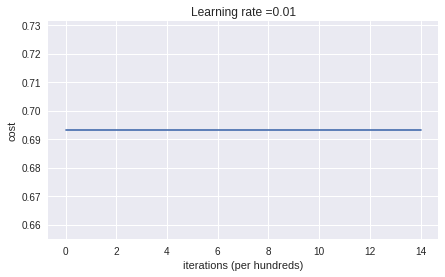

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [0]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The performance is really bad, and the cost does not really decrease, and the algorithm performs no better than random guessing. Why? Lets look at the details of the predictions and the decision boundary:

In [0]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


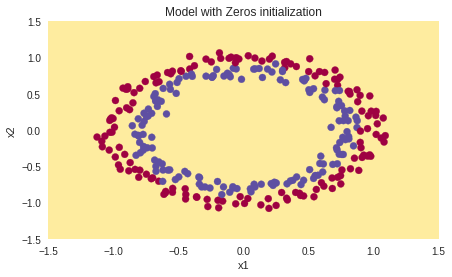

In [0]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The model is predicting 0 for every example. 

In general, initializing all the weights to zero results in the network failing to break symmetry. This means that every neuron in each layer will learn the same thing, and you might as well be training a neural network with $n^{[l]}=1$ for every layer, and the network is no more powerful than a linear classifier such as logistic regression. 

<font color='blue'>
**What you should remember**:
- The weights $W^{[l]}$ should be initialized randomly to break symmetry. 
- It is however okay to initialize the biases $b^{[l]}$ to zeros. Symmetry is still broken so long as $W^{[l]}$ is initialized randomly. 


## 3 - Random initialization

To break symmetry, lets intialize the weights randomly. Following random initialization, each neuron can then proceed to learn a different function of its inputs. In this exercise, you will see what happens if the weights are intialized randomly, but to very large values. 

**Exercise**: Implement the following function to initialize your weights to large random values (scaled by \*10) and your biases to zeros. Use `np.random.randn(..,..) * 10` for weights and `np.zeros((.., ..))` for biases. We are using a fixed `np.random.seed(..)` to make sure your "random" weights  match ours, so don't worry if running several times your code gives you always the same initial values for the parameters. 

In [0]:
# GRADED FUNCTION: initialize_parameters_random

def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])* 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1)) 
        ### END CODE HERE ###

    return parameters

In [0]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


**Expected Output**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[-0.82741481 -6.27000677]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Run the following code to train your model on 15,000 iterations using random initialization.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 0: inf
Cost after iteration 1000: 0.764430760917123
Cost after iteration 2000: 0.6694497819748406
Cost after iteration 3000: 0.6514608612543392
Cost after iteration 4000: 0.6470490153022801
Cost after iteration 5000: 0.6447551204661851
Cost after iteration 6000: 0.6411815985380511
Cost after iteration 7000: 0.6285418936546768
Cost after iteration 8000: 0.5973691240465535
Cost after iteration 9000: 0.5508662249571675
Cost after iteration 10000: 0.5076087656372772
Cost after iteration 11000: 0.490457997580895
Cost after iteration 12000: 0.47909323950405935
Cost after iteration 13000: 0.4745092019147147
Cost after iteration 14000: 0.47144805949387963


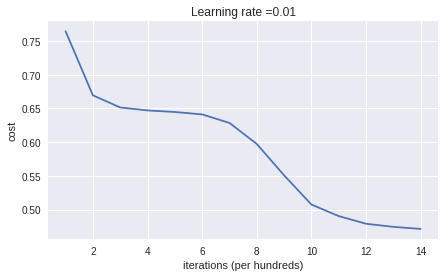

On the train set:
Accuracy: 0.6833333333333333
On the test set:
Accuracy: 0.67


In [0]:
parameters = model(train_X, train_Y, initialization = "random")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

If you see "inf" as the cost after the iteration 0, this is because of numerical roundoff; a more numerically sophisticated implementation would fix this. But this isn't worth worrying about for our purposes. 

Anyway, it looks like you have broken symmetry, and this gives better results. than before. The model is no longer outputting all 0s. 

In [0]:
print (predictions_train)
print (predictions_test)

[[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0
  1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
  1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1
  1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
  1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
  1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 0 1 1 1 1 1 0]]
[[1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1
  0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1]]


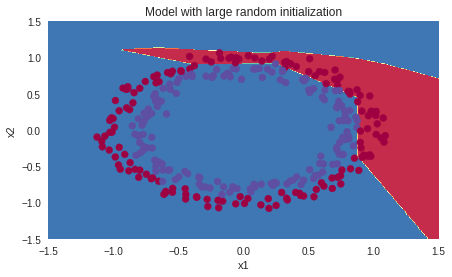

In [0]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The cost starts very high. This is because with large random-valued weights, the last activation (sigmoid) outputs results that are very close to 0 or 1 for some examples, and when it gets that example wrong it incurs a very high loss for that example. Indeed, when $\log(a^{[3]}) = \log(0)$, the loss goes to infinity.
- Poor initialization can lead to vanishing/exploding gradients, which also slows down the optimization algorithm. 
- If you train this network longer you will see better results, but initializing with overly large random numbers slows down the optimization.

<font color='blue'>
**In summary**:
- Initializing weights to very large random values does not work well. 
- Hopefully intializing with small random values does better. The important question is: how small should be these random values be? Lets find out in the next part! 

## 4 - He initialization

Finally, try "He Initialization"; this is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

**Exercise**: Implement the following function to initialize your parameters with He initialization.

**Hint**: This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [0]:
# GRADED FUNCTION: initialize_parameters_he

def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        ### START CODE HERE ### (≈ 2 lines of code)
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1])*np.sqrt(2/(layers_dims[l-1]))*10
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        ### END CODE HERE ###
        
    return parameters

In [0]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[5.50797903 7.08147823]
 [2.90904739 5.10827605]
 [8.92946954 8.96293089]
 [1.2558531  2.07242878]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0.36392808 3.1169963  0.21125671 3.23029871]]
b2 = [[0.]]


**Expected Output**:

<table> 
    <tr>
    <td>
    **W1**
    </td>
        <td>
    [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
    </td>
    </tr>
    <tr>
    <td>
    **b1**
    </td>
        <td>
    [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
    </td>
    </tr>
    <tr>
    <td>
    **W2**
    </td>
        <td>
    [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
    </td>
    </tr>
    <tr>
    <td>
    **b2**
    </td>
        <td>
    [[ 0.]]
    </td>
    </tr>

</table> 

Run the following code to train your model on 15,000 iterations using He initialization.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 0: inf
Cost after iteration 1000: 0.6987144243653535
Cost after iteration 2000: 0.5393265058065746
Cost after iteration 3000: 0.4668963603574266
Cost after iteration 4000: 0.4305787638496474
Cost after iteration 5000: 0.40845000324622827
Cost after iteration 6000: 0.39226904282981073
Cost after iteration 7000: 0.37841494018176863
Cost after iteration 8000: 0.36639610136508377
Cost after iteration 9000: 0.35277306242022477
Cost after iteration 10000: 0.34393541796130933
Cost after iteration 11000: 0.3395913097058186
Cost after iteration 12000: 0.3347392817171662
Cost after iteration 13000: 0.33143411106892284
Cost after iteration 14000: 0.3274889285345181


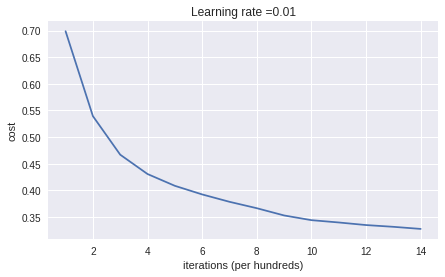

On the train set:
Accuracy: 0.7866666666666666
On the test set:
Accuracy: 0.79


In [0]:
parameters = model(train_X, train_Y, initialization = "he")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

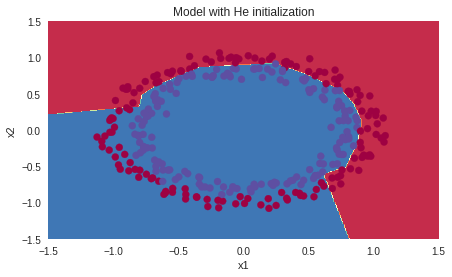

In [0]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The model with He initialization separates the blue and the red dots very well in a small number of iterations.


## 5 - Conclusions

You have seen three different types of initializations. For the same number of iterations and same hyperparameters the comparison is:

<table> 
    <tr>
        <td>
        **Model**
        </td>
        <td>
        **Train accuracy**
        </td>
        <td>
        **Problem/Comment**
        </td>

    </tr>
        <td>
        3-layer NN with zeros initialization
        </td>
        <td>
        50%
        </td>
        <td>
        fails to break symmetry
        </td>
    <tr>
        <td>
        3-layer NN with large random initialization
        </td>
        <td>
        83%
        </td>
        <td>
        too large weights 
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with He initialization
        </td>
        <td>
        99%
        </td>
        <td>
        recommended method
        </td>
    </tr>
</table> 

<font color='blue'>
**What you should remember from this notebook**:
- Different initializations lead to different results
- Random initialization is used to break symmetry and make sure different hidden units can learn different things
- Don't intialize to values that are too large
- He initialization works well for networks with ReLU activations. 